In [3]:
from numpy.random import randn
from filterpy.kalman import UnscentedKalmanFilter as UKF
from filterpy.common import Q_discrete_white_noise

from filterpy.kalman import MerweScaledSigmaPoints
import numpy as np
import matplotlib.pyplot as plt

UKF implementation assuming that sensor data is sampled at high frequency so that displacement is linear.

Implentation in 3D where x$_i \rightarrow $ i corresponds to dimension 

\begin{align}
x = \begin{bmatrix} x & \dot{x} & \ddot{x} & y & \dot{y} & \ddot{y} & z & \dot{z} & \ddot{z} \end{bmatrix}^T
\end{align}

per dimension 

\begin{align}
F = \begin{bmatrix} 1 & dt & dt^2 \\ 0 & 1 & dt \\ 0 & 0 & 1 \end{bmatrix}
\end{align}

\begin{align}
Q = \begin{bmatrix} \frac{1}{4}dt^4 & \frac{1}{2}dt^3 & \frac{1}{2}dt^3  \\ \frac{1}{2}dt^3 & dt^2 & \frac{1}{2}dt^3  \\ \frac{1}{2}dt^3 & \frac{1}{2}dt^3 & dt  \end{bmatrix}
\end{align}

\begin{align}
R = \begin{bmatrix} \sigma_s^2 & 0 & 0 \\ 0 & \sigma_s^2 & 0 \\  0 & 0 & \sigma_s^2 \\ \end{bmatrix}
\end{align}

\begin{align}
R = \begin{bmatrix} \sigma_s^2 & 0 & 0 \\ 0 & \sigma_s^2 & 0 \\  0 & 0 & \sigma_s^2 \\ \end{bmatrix}
\end{align}

\begin{align}
H = \begin{bmatrix} 0 & 0 & 1 & 0 & 0 & 0 & 0 & 0 & 0 \\ 0 & 0 & 0 & 0 & 0 & 1 & 0 & 0 & 0 \\ 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 1 \\ \end{bmatrix}
\end{align}


In [6]:
def f_cv(x, dt):
    """ state transition function for a 
    constant velocity aircraft"""
    
    F = np.array([[1, dt, dt**2, 0, 0, 0, 0, 0, 0],
                  [0, 1, dt, 0, 0, 0, 0, 0, 0],
                  [0, 0, 1, 0, 0, 0, 0, 0, 0],
                  [0, 0, 0, 1, dt, dt**2, 0, 0, 0],
                  [0, 0, 0, 0, 1, dt, 0, 0, 0],
                  [0, 0, 0, 0, 0, 1, 0, 0, 0],
                  [0, 0, 0, 0, 0, 0, 1, dt, dt**2],
                  [0, 0, 0, 0, 0, 0, 0, 1, dt],
                  [0, 0, 0, 0, 0, 0, 0, 0, 1]])
    return F @ x

def h_cv(x):
    return x[[2, 5, 8]]


In [71]:
std_x, std_y, std_z = 15, 10, 4

zs = [np.array([i + randn()*std_x, 
                1.5*i + randn()*std_y, 
                2*i + randn()*std_z]) for i in range(100)]
zs = np.array(zs)

In [72]:
dt = 1/10

time = np.arange(100)*dt

sigmas = MerweScaledSigmaPoints(9, alpha = .1, beta = 2., kappa = 1.)
ukf = UKF(dim_x=9, dim_z=3, fx=f_cv,
          hx=h_cv, dt=dt, points=sigmas)
sigmaSensor = 1

ukf.x = np.array([0., 0., 0., 0., 0., 0., 0., 0., 0.]) #initial position

ukf.R = np.diag([sigmaSensor**2, sigmaSensor**2, sigmaSensor**2]) #Measurement noise

#Process noise, variables within the dimension not independent but between dimensions yes
ukf.Q[0:3, 0:3] = Q_discrete_white_noise(3, dt=1, var=0.2)
ukf.Q[3:6, 3:6] = Q_discrete_white_noise(3, dt=1, var=0.2) 
ukf.Q[6:9, 6:9] = Q_discrete_white_noise(3, dt=1, var=0.2) 

uxs = []
for z in zs:
    ukf.predict()
    ukf.update(z)
    uxs.append(ukf.x.copy())
    
uxs = np.array(uxs)


Text(0, 0.5, 'a [m/s$^2$]')

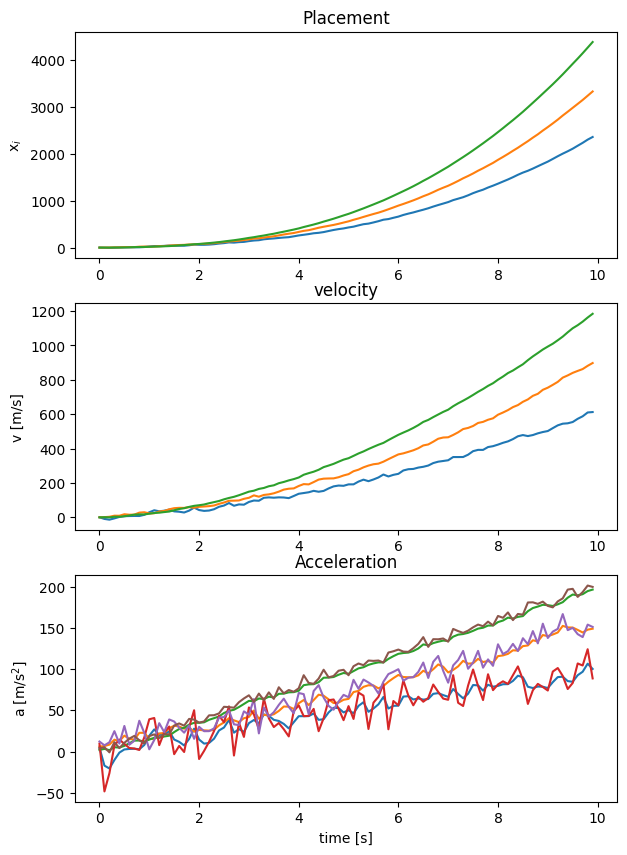

In [74]:
fig, ax = plt.subplots(3, 1, figsize = (7,10))

ax[0].set_title("Placement")


ax[0].plot(time,uxs[:,0], label = "x")
ax[0].plot(time,uxs[:,3], label = "y")
ax[0].plot(time,uxs[:,6], label = "z")

ax[1].set_title("Velocity")

ax[1].plot(time,uxs[:,1], label = "x")
ax[1].plot(time,uxs[:,4], label = "y")
ax[1].plot(time,uxs[:,7], label = "z")

ax[2].set_title("Acceleration")

ax[2].plot(time,uxs[:,2], label = "x-filtered")
ax[2].plot(time,uxs[:,5], label = "y-filtered")
ax[2].plot(time,uxs[:,8], label = "z-filtered")

ax[2].plot(time,zs[:,0], label = "x-raw")
ax[2].plot(time,zs[:,1], label = "y-raw")
ax[2].plot(time,zs[:,2], label = "z-raw")

ax[2].set_xlabel("time [s]")

ax[0].set_ylabel(r"x$_i$")
ax[1].set_ylabel("v [m/s]")
ax[2].set_ylabel(r"a [m/s$^2$]")